**Text description**

Imports 

In [1]:
!git clone -b ISF --single-branch https://github.com/efidvir/MA_QL
!pip install -U pygame
import numpy as np
import gym
from gym import spaces
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time
import os, sys
os.environ["SDL_VIDEODRIVER"] = "dummy"
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 300

sys.path.insert(0,'/content/MA_QL/')
from agents import Q_transmit_agent
from agents import AC_Agent
from env import transmit_env
from visualize import render
draw = render()

fatal: destination path 'MA_QL' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Simulation parameters
As there are more agents in the network, the number of iterations must be increased and the decay rate must be slower respectivly. The state space (battery size and silent time) must also be large enough.


In [2]:
agent_type = 'Q_Learning'
number_of_agents = 6

#Global learning parameters
number_of_iterations = 500000
force_policy_flag = True
np.random.seed(0)

#Agent model
MAX_SILENT_TIME = 12
SILENT_THRESHOLD = 1
BATTERY_SIZE = 12
DISCHARGE = number_of_agents -1
MINIMAL_CHARGE = number_of_agents -1
CHARGE = 1
number_of_actions = 2

#Agent learning params
GAMMA = 0.9
ALPHA = 0.01
#P_LOSS = 0
decay_rate = 0.99999

#for rendering
DATA_SIZE = 10


#Agent traning 

In [3]:
'''run realtime experiences'''

policies = [[] for i in range(number_of_agents)]
values = [[] for i in range(number_of_agents)]
occupied = 0
epsilon = np.ones(number_of_agents)
print(epsilon)

# initialize environment
env = [[] for i in range(number_of_agents)]
agent = [[] for i in range(number_of_agents)]
state = [[] for i in range(number_of_agents)]
actions = [[] for i in range(number_of_agents)]
transmit_or_wait_s = [[] for i in range(number_of_agents)]
score = [[] for i in range(number_of_agents)]
RAND = [[np.random.randint(10000)] for i in range(number_of_agents)]

for i in range(number_of_agents):
    #epsilon[i] = epsilon[i] -1/(number_of_agents+i)
    env[i] = transmit_env(BATTERY_SIZE, MAX_SILENT_TIME, (i+3), MINIMAL_CHARGE, DISCHARGE, CHARGE, DATA_SIZE, number_of_actions)
    if agent_type == 'Q_Learning':
        agent[i] = Q_transmit_agent(ALPHA, GAMMA, BATTERY_SIZE, MAX_SILENT_TIME, DATA_SIZE, number_of_actions, MINIMAL_CHARGE,RAND[i])
    elif agent_type == 'Actor-Critic':
        agent[i] = AC_Agent(5*i*0.0000008, GAMMA, BATTERY_SIZE, MAX_SILENT_TIME, DATA_SIZE, number_of_actions,MINIMAL_CHARGE)
        print('Make sure to adjust the learning rate')
    state[i] = env[i].initial_state
    actions[i] , transmit_or_wait_s[i] = agent[i].choose_action(state[i], epsilon[i])
    policies[i] = agent[i].get_policy()
    values[i] = agent[i].get_state_value(policies[i])

errors = [[] for i in range(number_of_agents)]

for i in range(number_of_iterations):

    # all agents move a step and take a new action
    for j in range(number_of_agents):
        env[j].state = env[j].new_state
    # Gateway decision
    if sum(transmit_or_wait_s) > 1 or sum(transmit_or_wait_s) == 0:
        ack = 0
    elif sum(transmit_or_wait_s) == 1:
        ack = 1

    for j in range(number_of_agents):
        new_state, reward, occupied = env[j].time_step(actions[j], transmit_or_wait_s[j], sum(transmit_or_wait_s), ack)  # CHANNEL

        env[j].new_state = new_state
        score[j].append(reward)
        np.random.seed(j)
        actions[j], transmit_or_wait_s[j] = agent[j].step(env[j].state, reward, actions[j], transmit_or_wait_s[j], env[j].new_state, epsilon[j])
        epsilon[j] = epsilon[j] * decay_rate
    if i % 100 == 0:
        print('step: ', i, '100 steps AVG mean score: ',np.mean(score[0][-100:-1]),'            epsilon:  ' ,epsilon[0])

print(epsilon)



[1. 1. 1. 1. 1. 1.]
step:  0 100 steps AVG mean score:  nan             epsilon:   0.99999
step:  100 100 steps AVG mean score:  0.030303030303030304             epsilon:   0.9989905048333954
step:  200 100 steps AVG mean score:  -0.06060606060606061             epsilon:   0.9979920086673684


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


step:  300 100 steps AVG mean score:  0.020202020202020204             epsilon:   0.9969945105034138
step:  400 100 steps AVG mean score:  0.010101010101010102             epsilon:   0.9959980093440235
step:  500 100 steps AVG mean score:  0.030303030303030304             epsilon:   0.9950025041926851
step:  600 100 steps AVG mean score:  0.030303030303030304             epsilon:   0.9940079940538837
step:  700 100 steps AVG mean score:  -0.04040404040404041             epsilon:   0.9930144779330995
step:  800 100 steps AVG mean score:  -0.21212121212121213             epsilon:   0.9920219548368061
step:  900 100 steps AVG mean score:  -0.13131313131313133             epsilon:   0.9910304237724702
step:  1000 100 steps AVG mean score:  -0.23232323232323232             epsilon:   0.9900398837485513
step:  1100 100 steps AVG mean score:  -0.1414141414141414             epsilon:   0.9890503337744988
step:  1200 100 steps AVG mean score:  -0.20202020202020202             epsilon:   0.98806

# **WSN Evaluation** with trained agents

collisions 0
agent0 [167.]
agent1 [167.]
agent2 [167.]
agent3 [166.]
agent4 [166.]
agent5 [167.]
wasted 0


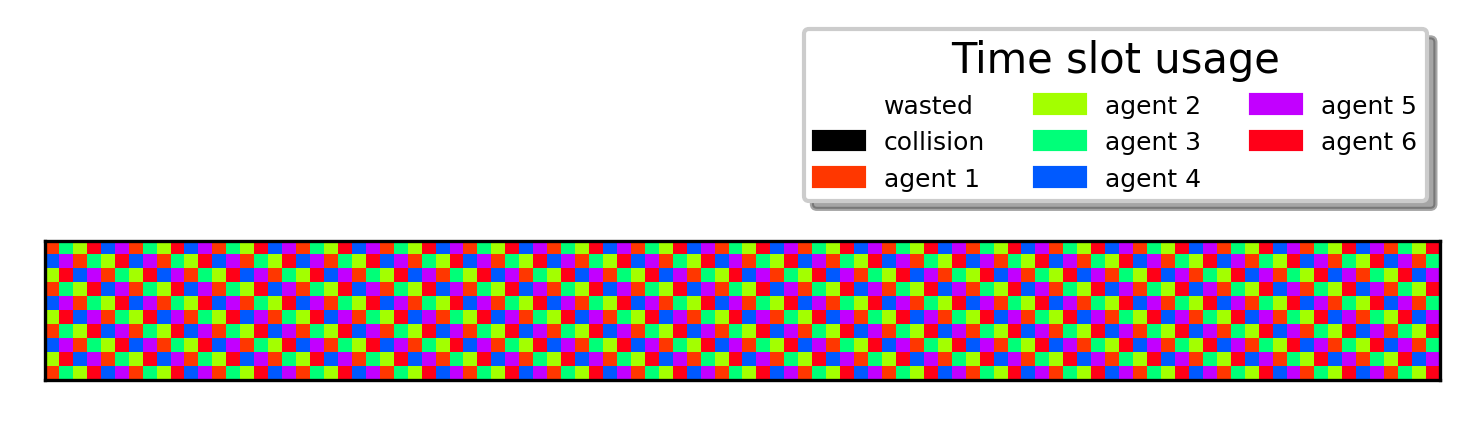

In [4]:
# No exploration
epsilon = np.zeros(number_of_agents)

data = []
collisions = 0
agent_clean = [np.zeros(1) for i in range(number_of_agents)]
wasted = 0

num_of_eval_iner = 1000

for i in range(num_of_eval_iner):
    for a in range(number_of_agents):
        env[a].state = env[a].new_state

    # Gateway decision
    if sum(transmit_or_wait_s) > 1 or sum(transmit_or_wait_s) == 0:
        ack = 0
    elif sum(transmit_or_wait_s) == 1:
        ack = 1

    if sum(transmit_or_wait_s) > 1:
        collisions += 1
        data.append(1)
    if sum(transmit_or_wait_s) == 1:
        for a in range(number_of_agents):
            if transmit_or_wait_s[a] == 1:
                agent_clean[a] += 1
                data.append(a+2)
    if sum(transmit_or_wait_s) == 0:
        wasted += 1
        data.append(0)
    for a in range(number_of_agents):
        new_state, reward, occupied = env[a].time_step(actions[a],transmit_or_wait_s[a], sum(transmit_or_wait_s), ack)  # CHANNEL
        env[a].new_state = new_state
        actions[a] ,transmit_or_wait_s[a] = agent[a].step(env[a].state, reward, actions[a],transmit_or_wait_s[a], env[a].new_state, epsilon[a])

print('collisions', collisions)
for a in range(number_of_agents):
    print('agent{d}'.format(d=a), agent_clean[a])
print('wasted', wasted)
draw.last_1k_slots(data, number_of_agents)
